# Created on 12/2020

@author : V. Robin

GENERATION OF INITIAL CONDITION TO OBTAIN
A 3D intial condition from a isoline equation

Preliminary 0D computations with Cantera have been
performed by Said Taileib to obtain the ignition delay time
as function of temperature : tau=f(Tu).
The coefficient A and B of the linearized profile
Log(tau)=f(1/T) must be known before running this program.

This program do:
    - from the desired propagation speed of the
    ignition front, the profile Tu(x) is determined
    - for all x-point, i.e. all fresh temperature,
    a 0D computation is performed to obtain Tu(x,t)
    - The retained profile for IC of resident corresponds
    to a certain time t=ti0D
    - This profile is filled on the resident grid (density and Y1 values) by setting a specific isovalue on a line in the domain. This line can be seen as a level set function.

In [1]:
#Import of the libraries and functions used in this script
import math
import shapely.geometry as geom
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.pyplot as plt
from matplotlib import rc
import cantera as ct
import numpy as np
import os

# functions definition
def cut_polygon_by_line(polygon, line):
    merged = linemerge([polygon.boundary, line])
    borders = unary_union(merged)
    polygons = polygonize(borders)
    return list(polygons)

def column(matrix, i): #creation of a function to read a row in a matrix and write it to a vector
    return [row[i] for row in matrix]

In [2]:
#####################################
# Resident Domain and grid definition
#####################################
lx=0.3   # length x direction
#ly= 0.08  # length y direction
ly= 0.01  # length y direction
lz= ly  # length y direction
#
nx= 1e-4 # cell syze x direction
ny=nx    # cell syze y direction
nz=ny    # cell syze y direction
#
eps=0.000000001
nl_x=int(lx/nx+eps)   #number of cells in x
nq_x=nl_x+1           #number of points in x
nl_y=int(ly/ny+eps)   #number of cells in y
nq_y=int(nl_y)+1      #number of points in y
nl_z=int(lz/nz+eps)   #number of cells in z
nq_z=int(nl_z)+1      #number of points in z
#
print("The number of points is" , nq_x,'x',nq_y,'x',nq_z,'=',nq_x*nq_y*nq_z)
print("The number of cells is" , nl_x,'x',nl_y,'x',nl_z,'=',nl_x*nl_y*nl_z)

The number of points is 3001 x 101 x 101 = 30613201
The number of cells is 3000 x 100 x 100 = 30000000


In [3]:
################################
# Initial condition parameters
###############################
U = 40              # propagation speed of the ignition front desired
c= 1e-5             # ignition delay time of the most reactive mixture (of the initial state)
#
#########################################
# Chemistry parameters and gas properties
# From preliminary 0D cantera calculation
# Log(Tau)=f(1/T)
#########################################
#B=21547.968                    # Alka's value
#A=5.79243E-12                  # Alka's value
B=8028.414                      # Said's value
A=3.86582E-9                    # Said's value
Pressure=16.46*1.01325e5        # initial pressure
comp = 'H2:2.0,O2:1.0,N2:3.76'  # fresh gas composition
gas = ct.Solution('H2_Global-Said.cti') # Said global step chemistry
timestepadim=1/1000             # timestep adimentionned by ignition delay
n=int(10/timestepadim)          # number of time iteration
defaulttimestep=c*timestepadim  # cantera timestep based on the ignition delay of the most reactive mixture
nxc=nx                          # cantera x step : the best is equal to nx
print('u =', U)

u = 40


In [4]:
##################################################
# Cantera computation to define the fresh gas profile
##################################################
# Maximum length : it corresponds to the cantera computation length
# Not easy to define, it depends of the shape and position of the flame
# : too lagre and calculation is very long
# : too short and the profile is cut on the resident grid 
#
coeflength=1.2
length=math.sqrt(lx ** 2 + ly ** 2 + lz ** 2)*coeflength # choice max length of the domain mutiply by a coefficient
# number of cells and points in the cantera domain
nl=int(length/nxc+eps)
nq=int(nl)+1

length=nq*nxc
timestep=np.zeros(nq) # variable timestep
Tu=np.zeros(nq)       # initial temperature - calculated from cantera 0D curve fit
tau=np.zeros(nq)      # ignition delay time array (calculated from cantera 0D curve fit)
x1=np.zeros(nq)       # coordinates
# Loop to define the initial profil of fresh gas temperature leading to the right propagation speed.
# This is based on the Zeldovitch gradient (ignition delay gradient).
for i in range(nq):
    xx=i*nxc
    x1[i]=(i)*nxc  # x (m)
    Tu[i]=B/(math.log((((xx/U)+c)/A))) # Fresh gas temperature
    tau[i]=(xx/U)+c # ignition delay time
    # to use variable time step : calculation stop at n*tau[i]*timestepadim
    timestep[i]=((xx/U)+c)*timestepadim
    # to use constant time step : calculation stop at ti0D
    #timestep[i]=ti0D/n
    
print("Cantera length, corresponding points and cells" ,length, nq, nl)
print("Temperature range for cantera" ,Tu[0],Tu[nq-1])
print("Position range" ,x1[0],x1[nq-1])
print("Range of ignition delay time" ,tau[0], tau[nq-1])

Cantera length, corresponding points and cells 0.3604 3604 3603
Temperature range for cantera 1021.6650343114005 547.5472722933587
Position range 0.0 0.3603
Range of ignition delay time 1e-05 0.0090175


In [5]:
################################################
# Cantera computations for all fresh temperatures
################################################
# Cantera loop for reactor solving with time (runned until it reaches the n*timestepadim i.e. 10 x ignition time)
# Declaration of the results matrix using the divison of the domain set and the maximum number of iterations to reach the max temperature
resu = np.zeros((nq,n))  # temperature results
resu1 = np.zeros((nq,n)) # Y results (gas composition) absolute value
resu2 = np.zeros((nq,n)) # Normalized Y
resu3 = np.zeros((nq,n)) # Normalized Y
times = np.zeros((nq,n))
for i in range(nq):          # loop on each position of the 1D profile
    time = 0.0               
    Temperature=Tu[i]        # fresh gas temperature
    Tempdata=[]              
    Ydata=[]
    rhodata=[]
    gas.TPX = Temperature, Pressure, comp          # gas definition
    r = ct.IdealGasConstPressureReactor(gas)       # reactor definition
    sim = ct.ReactorNet([r])                       # network reactor definition
    Tempdata.append(Temperature)                   # Recording of first temperature value
    Ydata.append(r.Y)
    rhodata.append(r.density)
    for j in range(n-1):       # Cantera time loop
        time+=timestep[i]
        sim.advance(time)
        Tempdata.append(r.T)
        Ydata.append(r.Y)
        rhodata.append(r.density)
    resu[i,:]=Tempdata            # Temperature stored
    resu1[i,:]=column(Ydata, 0)   # First species stored
    resu3[i,:]=rhodata            # rho stored
    for j in range(n):
        times[i,j]= j*timestep[i]                                      # times stored
        resu2[i,j]=(resu1[i,j]-resu1[i,n-1])/(resu1[i,0]-resu1[i,n-1]) # Normalized value of the first species stored
        
print('End Cantera loop')

End Cantera loop


fresh Temperature most reactive :  1021.6650343114005
fresh Temperature less reactive :  547.5472722933587


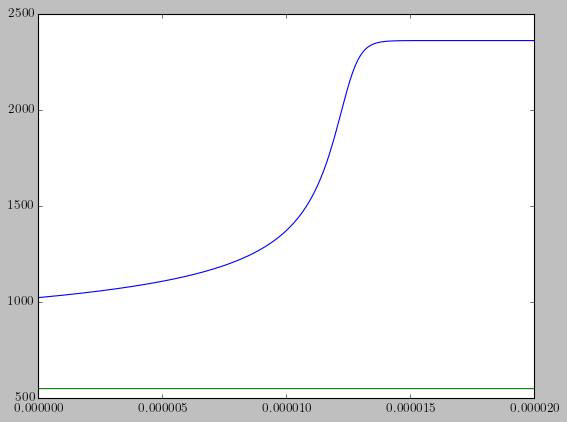

In [6]:
################################################
# Plot of cantera results : Two time profile
# corresponding to the extreme position in the 1D profile
# i.e. the most and less reactive mixture
################################################
plt.style.use('classic')
rc('font',**{'family':'DejaVu Sans','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=12)
print('fresh Temperature most reactive : ', resu[0,0])
print('fresh Temperature less reactive : ', resu[nq-1,0])
plt.plot(times[0,:],resu[0,:])
plt.plot(times[nq-1,:],resu[nq-1,:]) 
plt.xlim(0, 0.00002)
#plt.legend()
plt.show()

In [7]:
################################################
# Selection of the gas state corresponding to time ti0D
# for the whole points of the 1D profile
################################################
kit=np.zeros((nq),int)      # position of ti0D in arrays (necessary for variable time step)
ti0D=100*c                 # cantera time used to obtain partially burnt gas in the cantera domain.
                            # It must be higher than c (ignition time of the most reactive) to have burnt gas
T = np.zeros(nq)
T0 = np.zeros(nq)
Tb = np.zeros(nq)
Y1 = np.zeros(nq)
rho = np.zeros(nq)
rho0 = np.zeros(nq)
rhob = np.zeros(nq)
for i in range(nq):
    kit[i]=int(ti0D/timestep[i]) # position of the time ti0D in arrays
    T0[i]=resu[i, 0]
    rho0[i]=resu3[i, 0]
    Tb[i]=resu[i, n-1]
    rhob[i]=resu3[i, n-1]
    if (kit[i]<n):
        T[i]=resu[i, kit[i]]
        Y1[i]=resu2[i,kit[i]]
        rho[i]=resu3[i,kit[i]]
    else:
        T[i]=resu[i,n-1]
        Y1[i]=resu2[i,n-1]
        rho[i]=resu3[i,n-1]
print('Cantera time used as initial condition: ', ti0D)

Cantera time used as initial condition:  0.001


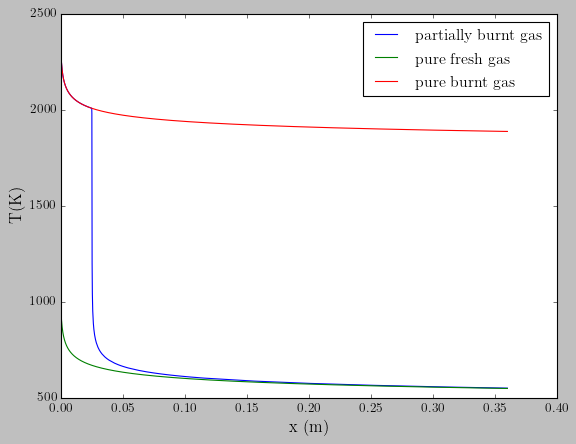

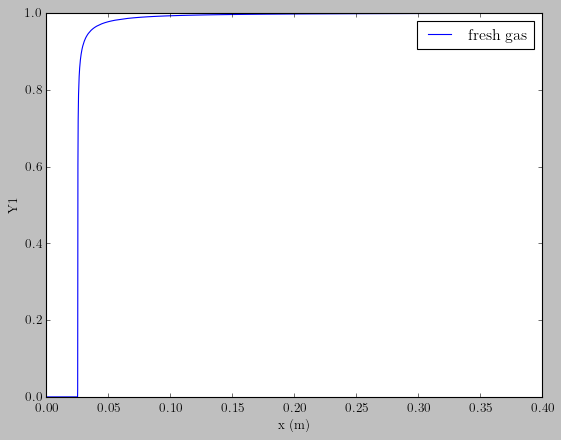

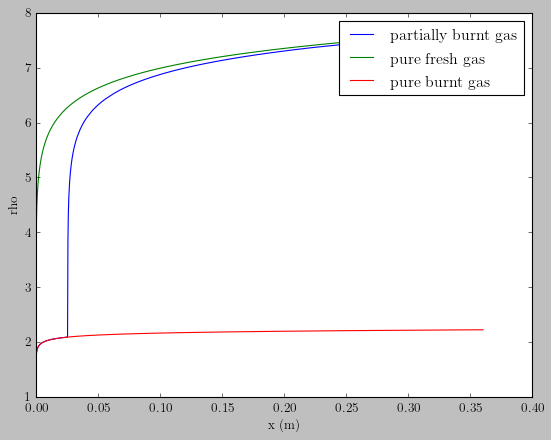

In [8]:
################################################
# PLot 1D profile corresponding to fully fresg gas,
# fully burnt gas and gas state att ti0D
################################################
plt.style.use('classic')
rc('font',**{'family':'DejaVu Sans','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=12)
trace=1
if (trace==1):
    plt.plot(x1,T,label=' partially burnt gas' ) 
    plt.plot(x1,T0,label='pure fresh gas' ) 
    plt.plot(x1,Tb,label='pure burnt gas' ) 
    plt.xlabel('x (m)',fontsize=15)
    plt.ylabel('T(K)',fontsize=15)
    plt.legend()
    plt.show()
   #
    plt.plot(x1,Y1,label='fresh gas')
    plt.xlabel('x (m)')
    plt.ylabel('Y1')
    plt.legend()
    plt.show()

    plt.plot(x1,rho,label='partially burnt gas')
    plt.plot(x1,rho0,label='pure fresh gas')
    plt.plot(x1,rhob,label='pure burnt gas')
    plt.xlabel('x (m)')
    plt.ylabel('rho')
    plt.legend()
    plt.show()

In [9]:
################################################
# Find the x position in 1D profile corresponding to
# a certain value of Y. This result is used to set the
# position of the 1D profile in the 2D resident domain
################################################
Yvalue=0.5
idx = (np.abs(Y1-Yvalue)).argmin()
flame_pos=x1[idx]
print('Total number of point in the 1D profile :', nq)
print('Point position in array :', idx ,'corresponding to the nearest value of Y=', Yvalue)
print('Y and x value at this point :', Y1[idx],x1[idx])

Total number of point in the 1D profile : 3604
Point position in array : 253 corresponding to the nearest value of Y= 0.5
Y and x value at this point : 0.4134884857561266 0.0253


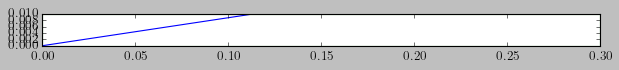

In [10]:
################################################
# DEFINTION DE LA POSITION DE LA FLAMME IN 2D RESIDENT
# CAS D'UNE DROITE D'ANGLE THETA
################################################
# On créé d'abord une isoligne sur une partie du domaine 
# (des symetries seront réalisées pour compléter le domaine)
# L'isoligne représente la "flamme" qui  sépare les gaz frais des gaz brulés
#
# Point de départ de l'isoligne
xini=0.0 
#yini=ly/2.0
yini=0.0
theta = 85   # angle (degrees) of the front with respect to the vertical axis
points_of_isoligne = []
#
# pour avoir une structure dont la forme est maintenu, il faut mettre les points extérieurs 0) et 2).
# pour avoir une vitesse constante du front, il faut supprimer les points extérieurs 0) et 2).
shape_maintained = 1 
#
if (theta>eps):
    if (shape_maintained==1):
        # 0) extérieur du domaine : on rajoute des points à l'extérieur du domaine si besoin  : POUR X<XINI x=0
        points_of_isoligne.append((0,0))
    #
    # 1) on boucle sur toutes les positions y correspondants aux points du maillage.
    #for j in range(int(nl_y)+1):
    for j in range(int(nl_y/2)+1):
        y_isoline = yini+j*ny # coordonnées y
        # coordonnées x de la forme désirée (ici une droite d'angle theta)
        x_isoline = xini + (yini+y_isoline)*math.tan(math.radians(theta))
        # création du tableau de coordonées des points
        points_of_isoligne.append((x_isoline,y_isoline))
        #print(j, x_isoline,y_isoline)
    #
    if (shape_maintained==1):
        # 2) extérieur du domaine : on rajoute des points à l'extérieur du domaine si besoin : POUR X>XMAXI x=lx
        # ici on prend un point loin : le max de coordonnées x pour prolonger la droite
        points_of_isoligne.append((lx,-yini+(lx-xini)/math.tan(math.radians(theta))))
    #points_of_isoligne.append((x_isoline,ly))
    #
else:
    points_of_isoligne.append((xini,0))
    points_of_isoligne.append((xini,ly))    
#
#
# création des objets géométriques
isoline = LineString(points_of_isoligne) # on créé une ligne avec ces points
demidomaine = Polygon([(0, 0), (0, ly), (lx, ly), (lx, 0)]) # polygone du domaine
domaine_parts = cut_polygon_by_line(demidomaine, isoline) # découpage du polygone en deux
if (theta>eps):
    domaine_bunrt = domaine_parts[0] # Création d'un polygone représentant les gaz brulés
else:
    domaine_bunrt = domaine_parts[1] # Création d'un polygone représentant les gaz brulés    
#
#plt.plot(demidomaine)
xbunrt,ybunrt = domaine_bunrt.exterior.xy
xfull,yfull = demidomaine.exterior.xy
plt.figure(figsize=(30*lx,100*ly/2))
plt.plot(xbunrt,ybunrt)
plt.plot(xfull,yfull)
plt.show()

In [11]:
################################################
# REMPLISSAGE DES TABLEAUX DE CONDITION INITIALE
# on remplie seulement la moitié du domaine en y
# des symétries sont utilisées ensuite lors
# de l'écriture dans les fichiers
################################################
#CI_rho = np.zeros((nl_x,int(nl_y/2)))
CI_rho = np.zeros(shape=(nl_x,nl_y,nl_z))
CI_Y   = np.zeros(shape=(nl_x,nl_y,nl_z))
gmax=nq
for k in range(nl_z):
    for j in range(nl_y):
        for i in range(nl_x):
            # changme,t de repere : cylindrique
            x=nx/2+i*nx # x centre des cellules
            y=math.sqrt( (ny/2+j*ny-ly/2)**2 + (nz/2+k*nz-lz/2)**2 ) # y centre des cellules
            
            localpoint = Point(x,y) # création d'un point correspondant au centre de la cellule
            # point le plus près sur l'isoligne de la flamme
            #nearest_point_on_isoline = isoline.interpolate(isoline.project(localpoint))
            # distance entre le point de la flamme et le centre de la cellule
            dist = localpoint.distance(isoline)
            # distance négative dans les gaz brulés
            if (domaine_bunrt.contains(localpoint)):
                dist = - dist

            #z=(x*math.cos ( math.radians ( theta ) )+ y*math.sin ( math.radians ( theta ) ))
            z=dist+flame_pos
            g=int(z/(nxc))
            # valeur de rho et Y1 sur la cellule par interpolation du profil cantera
            if (g < 0):
                CI_rho[i,j,k]=rho[0]
                CI_Y[i,j,k]=Y1[0]
            elif (g > gmax-2):
                CI_rho[i,j,k]=rho[gmax-1]
                CI_Y[i,j,k]=Y1[gmax-1]
            else:
                CI_rho[i,j,k]=(rho[g]+(((rho[g+1]-rho[g])/(x1[g+1]-x1[g])*(z-x1[g]))))
                CI_Y[i,j,k]=(Y1[g]+(((Y1[g+1]-Y1[g])/(x1[g+1]-x1[g])*(z-x1[g]))))
print('End filling loop')

End filling loop


In [12]:
################################################
# WRITTING FILES THAT ARE READ BY RESIDENT
################################################
#
# Number of cells stored in a specific file
filename = 'info.dat'
f = open(filename,'w')
f.write(str(nl_x)) #number of cells in x
f.write(' ')
f.write(str(nl_y)) #number of cells in y
f.write(' ')
f.write(str(nl_z))
f.close()
print('info.dat saved')
#
# Writting initial condition file for rho and Y 
filename1 = 'Density.dat'
filename2 = 'Y1.dat'
f1 = open(filename1,'w')
f2 = open(filename2,'w')


for k in range(int(nl_z)):
    for j in range(int(nl_y)):
        for i in range(nl_x):  
            f1.write('%13.5e' %CI_rho[i,j,k]) #density
            f2.write('%13.5e' %CI_Y[i,j,k]) #Y1       
            f1.write(' ')
            f2.write(' ')
        f1.write('\n')
        f2.write('\n')

#    for j in range(int(nl_y/2)):
#        for i in range(nl_x):  
#            jsym=int(nl_y/2)-1-j
#            f1.write('%13.5e' %CI_rho[i,jsym]) #density
#            f2.write('%13.5e' %CI_Y[i,jsym]) #Y1 
#            f1.write(' ')
#            f2.write(' ')
#        f1.write('\n')
#        f2.write('\n')

    
f1.close()
f2.close()
print('Density.dat and Y1.dat saved')
print("dimension to put in data.inp : ")
print("x=",nl_x*nx)
print("y=",nl_y*ny)
print("y=",nl_z*nz)

info.dat saved
Density.dat and Y1.dat saved
dimension to put in data.inp : 
x= 0.3
y= 0.01
y= 0.01
